# Comparison between HC$_3$N and NH$_3$

In [1]:
# original resolution: 4.07672 arcsec x 3.78778 arcsec, pa: -81.4035 deg 
# matching kernel: 4.65325 arcsec x 4.40231 arcsec, pa: 8.59652 deg 
# target resolution: 6 arcsec x 6 arcsec, pa: 0 deg
import numpy as np
from astropy.modeling.models import Gaussian2D
import astropy.units as u
from astropy.nddata import Cutout2D
from astropy.convolution import convolve
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from photutils.psf import create_matching_kernel, TopHatWindow
import matplotlib.pyplot as plt
from reproject import reproject_exact
import aplpy
from B5setup import *
from scipy import stats
from scipy.integrate import simpson
import os
%matplotlib inline

In [2]:
folderHC3N = 'B5_NOEMA_30m/gaussfit/'
maskfile = folderHC3N + 'B5-NOEMA+30m-H3CN-10-9_cut_K_mask'
# for velocity:
filenameHC3Nvlsr = folderHC3N + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr'
filenameHC3Nvlsr_u = folderHC3N + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr_unc'
filenameNH3vlsr = 'B5_previous_data/B5_VLA_GBT_model_vc_QA'
diffdatafile = 'B5_Vlsr_HC3N_minus_NH3'

# For Velocity dispersion :
# filenameHC3Nvlsr = folderHC3N + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_SigmaV'
# filenameNH3vlsr = 'B5_previous_data/B5_VLA_GBT_model_dv_QA'
# diffdatafile = 'B5_SigmaV_HC3N_minus_NH3'

filename_convolved = filenameHC3Nvlsr + '_conv_NH3'
filename_unc_convolved = filenameHC3Nvlsr_u + '_conv_NH3'
filenameNH3_convolved = filenameNH3vlsr + '_reprojectHC3N'


In [3]:
headerHC3N = fits.getheader(filenameHC3Nvlsr+'.fits')
headerNH3 = fits.getheader(filenameNH3vlsr+'.fits')
wcsHC3N = WCS(headerHC3N)
pixsizeHC3N = np.abs(headerHC3N['CDELT2']) # pixel size in degrees
pixsizeNH3 = np.abs(headerNH3['CDELT2'])

We first need to convolve the HC$_3$N to the resolution of NH$_3$

In [4]:
if not os.path.exists(filename_convolved + '.fits') or not os.path.exists(filename_unc_convolved + '.fits'):
# we first need to transform all angle units to pixels
    kernelsize = 29
    xcent = int(round(kernelsize/2))

    bmaj_original = headerHC3N['BMAJ']
    bmin_original = headerHC3N['BMIN']
    bpa_original = headerHC3N['BPA'] * u.deg
    sigmamaj_original_pix = (bmaj_original/pixsizeHC3N) / np.sqrt(8*np.log(2))
    sigmamin_original_pix = (bmin_original/pixsizeHC3N) / np.sqrt(8*np.log(2))
    bmaj_target = headerNH3['BMAJ']
    bmin_target = headerNH3['BMIN']
    bpa_target = headerNH3['BPA'] * u.deg
    sigmamaj_target_pix = (bmaj_target/pixsizeHC3N) / np.sqrt(8*np.log(2))
    sigmamin_target_pix = (bmin_target/pixsizeHC3N) / np.sqrt(8*np.log(2))
    
    y, x = np.mgrid[0:kernelsize, 0:kernelsize]
    beamoriginalg = Gaussian2D(100, xcent, xcent, sigmamaj_original_pix, sigmamin_original_pix, theta=bpa_original)
    beamtargetg = Gaussian2D(100, xcent, xcent, sigmamaj_target_pix, sigmamin_target_pix, theta=bpa_target)
    beamoriginal = beamoriginalg(x, y)
    beamtarget = beamtargetg(x, y)
    beamtarget /= np.sum(beamtarget)
    window = TopHatWindow(beta=0.45)
    matchingkernel = create_matching_kernel(beamoriginal, beamtarget, window=window)
    
    mask = fits.getdata(maskfile+'.fits')
    if not os.path.exists(filename_convolved + '.fits'):
        HC3Nvlsr = fits.getdata(filenameHC3Nvlsr+'.fits') 
    
        HC3Nvlsrconvolved = convolve(HC3Nvlsr, matchingkernel)
        HC3Nvlsrconvolved = np.where(mask, HC3Nvlsrconvolved, np.nan)

        newheaderHC3N = headerHC3N.copy()
        newheaderHC3N['BMAJ'] = bmaj_target
        newheaderHC3N['BMIN'] = bmin_target
        newheaderHC3N['BPA'] = bpa_target.value
    
        fits.writeto(filename_convolved+'.fits', HC3Nvlsrconvolved, newheaderHC3N)
        
    if not os.path.exists(filename_unc_convolved + '.fits'):
        HC3Nvlsr_u = fits.getdata(filenameHC3Nvlsr_u+'.fits')
        aprox_sigma_kernel = np.sqrt(sigmamaj_target_pix -sigmamaj_original_pix)
        
        matchingkernel_unc_factor = (2 * np.sqrt(np.pi) * sigmamaj_original_pix * aprox_sigma_kernel / np.sqrt(aprox_sigma_kernel**2 + sigmamaj_original_pix**2))
        matchingkernel_unc = matchingkernel ** 2 * matchingkernel_unc_factor
        HC3Nvlsr_uconvolved = convolve(HC3Nvlsr_u, matchingkernel_unc)
        HC3Nvlsr_uconvolved = np.where(mask, HC3Nvlsr_uconvolved, np.nan)

        newheaderHC3N = headerHC3N.copy()
        newheaderHC3N['BMAJ'] = bmaj_target
        newheaderHC3N['BMIN'] = bmin_target
        newheaderHC3N['BPA'] = bpa_target.value
    
        fits.writeto(filename_unc_convolved+'.fits', HC3Nvlsr_uconvolved, newheaderHC3N)
    HC3Nvlsrconvolved = fits.getdata(filename_convolved + '.fits')
    HC3Nvlsr_uconvolved = fits.getdata(filename_unc_convolved + '.fits')
else:
    HC3Nvlsrconvolved, newheaderHC3N = fits.getdata(filename_convolved + '.fits', header=True)
    HC3Nvlsr_uconvolved = fits.getdata(filename_unc_convolved + '.fits')

Now we need to regrid the NH$_3$ image to the HC$_3$N grid.

In [5]:
if not os.path.exists(filenameNH3_convolved+'.fits'):
    NH3hdu = fits.open(filenameNH3vlsr + '.fits')
    key_remove = ['PC03_01', 'PC04_01', 'PC01_03', 'PC02_03', 'PC03_02', 'PC04_02','PC03_03', 'PC04_03', 'PC01_04',
                  'PC02_04', 'PC03_04', 'PC04_04', 'CUNIT3', 'CRPIX4','CDELT4','CUNIT4','CTYPE4','CRVAL4','SPECSYS']
    for key_i in key_remove: # there are more dimensions written in the NH3 fits file
        NH3hdu[0].header.remove(key_i)
    newNH3image, footprint = reproject_exact(NH3hdu[0], newheaderHC3N)
    # now we modify the spatial properties of the NH3 Header
    newheaderNH3 = NH3hdu[0].header.copy() # we use this header as it has the resolution
    key_modify = ['CUNIT1', 'CRPIX1','CDELT1','CTYPE1','CRVAL1', 'CUNIT2', 'CRPIX2','CDELT2','CTYPE2','CRVAL2']
    for key_i in key_modify: # there are more dimensions written in the NH3 fits file
        newheaderNH3[key_i] = newheaderHC3N[key_i]

    fits.writeto(filenameNH3_convolved+'.fits', newNH3image, newheaderNH3)
    NH3hdu.close()
else:
    newNH3image = fits.getdata(filenameNH3_convolved+'.fits')

We look at the difference of HC$_3$N with respect to NH$_3$

In [6]:
diff = HC3Nvlsrconvolved - newNH3image
newhead = newheaderHC3N.copy()
newhead.remove('BUNIT')
if not os.path.exists(diffdatafile + '.fits'):
    fits.writeto(diffdatafile + '.fits', diff, newhead)


/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


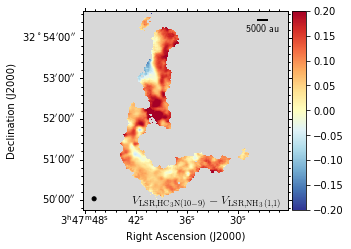

In [7]:
# we plot quickly the difference
fig = plt.figure(figsize=(4,4))
velmin = -0.2
velmax = 0.2
ax = plot_aplpy_subfig(diffdatafile + '.fits', 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r')
ax.add_label(0.6, 0.04, 
             r'$V_{\mathrm{LSR},\mathrm{HC}_3\mathrm{N}(10-9)} - V_{\mathrm{LSR}, \mathrm{NH}_3(1,1)}$', 
             relative=True, family='sans-serif', size=12)
# fig.savefig(folderHC3N + diffdatafile + '.pdf', bbox_inches='tight')

Now we do the KDE of the velocity difference distribution, first in 1 dimension and then in 2

In [8]:
# create the grid for the 1D kernel distribution
data_kde = np.linspace(-0.4, 0.4, 100)
data = fits.getdata(diffdatafile + '.fits').flatten()
data = data[~np.isnan(data)]
p_range = np.array([0.15865 * 100, 50., 0.84135 * 100]) # I believe this is one sigma? ask Jaime
vlsr_median_unc = np.round(np.percentile(data, p_range), decimals=2)

kernel = stats.gaussian_kde(data)
dens = kernel(data_kde)
dens /= simpson(dens, data_kde) # normalizing of probability

datasave = np.array([data_kde, dens, vlsr_median_unc], dtype=object)
if not os.path.exists(diffdatafile+'.npy'):
    np.save(diffdatafile+'.npy', datasave)

In [9]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.hist(data, fc='k', bins='fd', density=True)
# ax.plot(data_kde, dens)
# ax.set_xlim([-0.4, 0.4])
# ax.plot([vlsr_median_unc[1], vlsr_median_unc[1]], [0.5, 2], color='C1', ls='--')
# ax.text(vlsr_median_unc[1]-0.05,1.1,r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(vlsr_median_unc[1], vlsr_median_unc[0]-vlsr_median_unc[1], vlsr_median_unc[2]-vlsr_median_unc[1]), size=10, color='C1')


In [10]:
# This part only works for velocity
# x is v_LSR of HC3N
xmin = 9.8
xmax = 10.8
# y is v_LSR of NH3
ymin = 9.8
ymax = 10.8
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
# we select only those who are not nan
gd_vlos = np.isfinite(HC3Nvlsrconvolved * newNH3image)
values = np.vstack([HC3Nvlsrconvolved[gd_vlos], newNH3image[gd_vlos]])
# we calculate the kernel distribution
kernel = stats.gaussian_kde(values)
zz = np.reshape(kernel(positions).T, xx.shape)
zz /= zz.max()

datasave = np.array([xx, yy, zz])
if not os.path.exists(diffdatafile+'_2DKDE.npy'):
    np.save(diffdatafile+'_2DKDE.npy', datasave)


In [11]:
# just to check it quickly
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
# ax.plot([9.8, 10.8], [9.8, 10.8])

## Cuts along horizontal and vertical samples
We cut a box around the protostar and determine the position of maximum difference to plot the velocities of both molecules in horizontal and vertical cuts

In [12]:
position_irs1 = SkyCoord(ra_yso*u.deg, dec_yso*u.deg, frame='fk5')
boxsize = 50
wcs_diff = WCS(newhead)
cutout = Cutout2D(diff, position_irs1, (boxsize, boxsize), wcs=wcs_diff)
diff_small = cutout.data
y_min, x_min = np.unravel_index(np.nanargmin(diff_small), diff_small.shape)

In [13]:
# we need to cut both images
chansize_hc3n = 0.21 / np.sqrt(2*np.pi)/2.35
chansize_nh3 = 0.04 / np.sqrt(2*np.pi)/2.35 # ask if they are independent
cutout2 = Cutout2D(HC3Nvlsrconvolved, position_irs1, (boxsize, boxsize), wcs=wcs_diff)
hc3nvel_small = cutout2.data
cutout3 = Cutout2D(newNH3image, position_irs1, (boxsize, boxsize), wcs=wcs_diff)
nh3vel_small = cutout3.data

cutout4 = Cutout2D(HC3Nvlsr_uconvolved, position_irs1, (boxsize, boxsize), wcs=wcs_diff)
hc3nvel_small_u = cutout4.data

In [14]:
nh3vls_hor = nh3vel_small[y_min]
hc3nvls_hor = hc3nvel_small[y_min]
hc3nvls_hor_u = hc3nvel_small_u[y_min]
nh3vls_ver =nh3vel_small[:, x_min]
hc3nvls_ver = hc3nvel_small[:, x_min]
hc3nvls_ver_u = hc3nvel_small_u[:, x_min]
# add the beam
xarray = np.linspace(0, boxsize, boxsize) - x_min
yarray = np.linspace(0, boxsize, boxsize) - y_min

<ErrorbarContainer object of 3 artists>

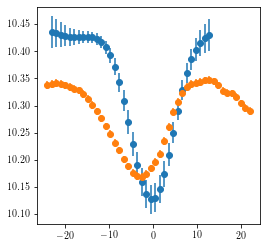

In [15]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)
ax.errorbar(xarray, hc3nvls_hor, yerr=hc3nvls_hor_u, color='C0', marker='o', linestyle='None')
ax.errorbar(xarray, nh3vls_hor, yerr=chansize_nh3, color='C1', marker='o', linestyle='None')

<ErrorbarContainer object of 3 artists>

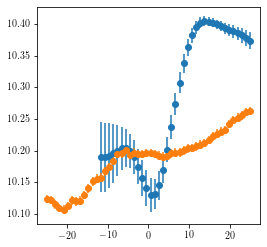

In [16]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)
ax.errorbar(yarray, hc3nvls_ver, yerr=hc3nvls_ver_u, color='C0', marker='o', linestyle='None')
ax.errorbar(yarray, nh3vls_ver, yerr=chansize_nh3, color='C1', marker='o', linestyle='None')